In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

# Importing plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette("pastel")
sns.set_style("white")
sns.set(rc={'figure.figsize':(8,8)})
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Importing Pandas and NumPy
import pandas as pd
import numpy as np
np.random.seed(0)

# Importing plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette("pastel")
sns.set_style("white")
sns.set(rc={'figure.figsize':(8,8)})
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tabulate import tabulate

import joblib

# Import machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import sklearn.neighbors._base
from xgboost import XGBRegressor

from scipy.stats import zscore

import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import warnings
warnings.filterwarnings("ignore")

In [2]:
# DFT Calculations
dft_calc = pd.read_csv("data/dft_calc.csv").replace(" ", 0)

# Elemental Properties
elemental_prop = pd.read_csv("data/elemental_properties.csv")
elemental_prop = elemental_prop.replace(" ", 0)

# Shannon Radii
shan_rad = pd.read_csv("data/shannon_radius.csv")

# Copy of dft_calc
df = dft_calc.copy()

In [3]:
a_shan_rad = shan_rad[["A_SITE","A_RADII"]]
b_shan_rad = shan_rad[["B_SITE","B_RADII"]]

In [4]:
a_shan_rad_sites = list(a_shan_rad["A_SITE"])
b_shan_rad_sites = list(b_shan_rad["B_SITE"])

a_shan_rad = list(a_shan_rad["A_RADII"])
b_shan_rad = list(b_shan_rad["B_RADII"])

## Data Setup

The dataset is derived from the work of Jacobs et al. who used density functional theory (DFT) methods to simulate 1,926 perovskite oxides to calculate their thermodynamic stability [1]. As shown below, their dataset contains 11 columns which includes the material name, the ions in the A-site, B-site and X-site, their energy above hull $E_{hull}$ in meV/atom, and their formation energy in meV/atom.

In [5]:
dft_calc.head()

,COMPOSITION,A_SITE_1,A_SITE_2,A_SITE_3,B_SITE_1,B_SITE_2,B_SITE_3,X_SITE,NUM_ELEMS,ENERGY_ABOVE_HULL,FORMATION_ENERGY
0,Ba1Sr7V8O24,Ba,Sr,NaN,V,NaN,NaN,O,4,29.747707,-2.113335
1,Ba2Bi2Pr4Co8O24,Ba,Bi,Pr,Co,NaN,NaN,O,5,106.702335,-1.311863
2,Ba2Ca6Fe8O24,Ba,Ca,NaN,Fe,NaN,NaN,O,4,171.608093,-1.435607
3,Ba2Cd2Pr4Ni8O24,Ba,Cd,Pr,Ni,NaN,NaN,O,5,284.898190,-0.868639
4,Ba2Dy6Fe8O24,Ba,Dy,NaN,Fe,NaN,NaN,O,4,270.007913,-1.746806


In [6]:
dft_calc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1926 entries, 0 to 1925
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   COMPOSITION        1926 non-null   object 
 1   A_SITE_1           1926 non-null   object 
 2   A_SITE_2           1159 non-null   object 
 3   A_SITE_3           34 non-null     object 
 4   B_SITE_1           1926 non-null   object 
 5   B_SITE_2           1247 non-null   object 
 6   B_SITE_3           33 non-null     object 
 7   X_SITE             1926 non-null   object 
 8   NUM_ELEMS          1926 non-null   int64  
 9   ENERGY_ABOVE_HULL  1926 non-null   float64
 10  FORMATION_ENERGY   1926 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 165.6+ KB


Another dataset from the work of Logan et al. is used to supplement the `dft_calc` dataset [2]. As seen below, the dataset contains information regarding the chemical and properties for each element in the periodic table. 

In [7]:
elemental_prop.head()

,SYMBOL,IONIC_RADIUS,MOD_OF_ELASTICITY,BP,MP,DENSITY,AT_WT,BCC_EFF_LAT_CNT,BCC_ENERGY,BCC_ENERGY_DIFF,...,IS_NONMETAL,ND_UNFILLED,ND_VALENCE,NF_UNFILLED,NF_VALENCE,NP_UNFILLED,NP_VALENCE,NS_UNFILLED,NS_VALENCE,N_UNFILLED
0,H,1.54,NaN,20.28,13.81,0.0899,1.00797,3.589268,-2.135811,1.195480,...,1,0,0,0,0,0,0,1,1,1
1,He,0,NaN,4.216,0.95,0.1785,4.0026,5.373995,-2.000673,-2.001808,...,1,0,0,0,0,0,0,0,2,0
2,Li,0.76,10.0,1615,453.7,0.53,6.941,6.416364,-1.865535,0.004352,...,0,0,0,0,0,0,0,1,1,1
3,Be,0.45,301.0,3243,1560,1.85,9.01218,4.997332,-3.655272,0.099767,...,0,0,0,0,0,0,0,0,2,0
4,B,0.23,441.0,4275,2365,2.34,10.811,4.606670,-4.966431,1.711267,...,0,0,0,0,0,5,1,0,2,5


In [8]:
elemental_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 82 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SYMBOL                  110 non-null    object 
 1   IONIC_RADIUS            110 non-null    object 
 2   MOD_OF_ELASTICITY       81 non-null     float64
 3   BP                      110 non-null    object 
 4   MP                      110 non-null    object 
 5   DENSITY                 110 non-null    object 
 6   AT_WT                   110 non-null    object 
 7   BCC_EFF_LAT_CNT         110 non-null    float64
 8   BCC_ENERGY              110 non-null    float64
 9   BCC_ENERGY_DIFF         110 non-null    float64
 10  BCC_FERMI               110 non-null    float64
 11  BCC_MAG_MOM             110 non-null    float64
 12  BCC_VOLUME_PA           110 non-null    float64
 13  BCC_VOLUME_DIFF         110 non-null    float64
 14  GS_BANDGAP              110 non-null    fl

## Data pre-processing

Most numerical features in the `elemental_prop` dataset are encoded as strings and should be converted to a data type that machine learning models can work on. Additionally, the column for ionization energy is encoded as strings with commas. The commas should be removed before converting str to float. The first column in `dft_calc`, for example, is shown below:

In [9]:
# Commas in the ionization energy column
elemental_prop["ION_ERGY"]

0          1312
1      2,372.30
2           520
3        899.40
4        800.60
         ...   
105           0
106           0
107           0
108           0
109           0
Name: ION_ERGY, Length: 110, dtype: object

In [10]:
# Removing commas on column `ION_ERGY`
elemental_prop["ION_ERGY"] = elemental_prop["ION_ERGY"].str.replace(",","")

# Creating list of numerical columns in elemental_prop that should be converted to float
col_names_no_symbol = [i for i in elemental_prop.columns if i != "SYMBOL"]

# Conversion to float
elemental_prop[col_names_no_symbol] = elemental_prop[col_names_no_symbol].astype("float")

## Dataset building

To build the actual dataset to be used for modeling, `dft_calc` and `elemental_prop` are joined using the elements in the different sites as key. 

In [11]:
dft_calc.iloc[0,:]

COMPOSITION          Ba1Sr7V8O24
A_SITE_1                      Ba
A_SITE_2                      Sr
A_SITE_3                     NaN
B_SITE_1                       V
B_SITE_2                     NaN
B_SITE_3                     NaN
X_SITE                         O
NUM_ELEMS                      4
ENERGY_ABOVE_HULL      29.747707
FORMATION_ENERGY       -2.113335
Name: 0, dtype: object

It has Ba and Sr in its A-sites, and V in its B-sites. The O in its X-site can be disregarded since all materials in the dataset are perovskite oxides and have O in their X-sites. The elemental properties of Ba, Sr, and V are joined into `dft_calc` with column names appended by the site the element is in.

In [12]:
# List of suffixes to append to elemental properties
# ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']
suffixes = "A1 A2 A3 B1 B2 B3".split()

# List of columns under dft_calc showing sites of elements
# To be used as key in merging 
# ['A_SITE_1', 'A_SITE_2', 'A_SITE_3', 'B_SITE_1', 'B_SITE_2', 'B_SITE_3']
site_names = list(dft_calc.columns[1:7])

# List of column names for symbols under placeholder dataframe 
# ['A1_SYMBOL', 'A2_SYMBOL', 'A3_SYMBOL', 'B1_SYMBOL', 'B2_SYMBOL', 'B3_SYMBOL']
symbol_names = [i+"_SYMBOL" for i in suffixes]

# Initializing empty list containing column names for 
# A-sites and B-sites
elemental_prop_col_names = []

# Populating elemental_prop_col_names
# Loops through all sites and creates site-specific column names for each
# elemental property
for i in range(6):
    placeholder_df = elemental_prop.copy()
    placeholder_df.columns = suffixes[i] + "_" + placeholder_df.columns.values
    dft_calc = pd.merge(dft_calc, placeholder_df, how="left", left_on=site_names[i], right_on=symbol_names[i])
    
    placeholder_df = placeholder_df.drop(columns=[suffixes[i] + "_SYMBOL"])
    elemental_prop_col_names.append(placeholder_df.columns)

Shown below is a list containing new column names for Site A1. In the case of Ba1Sr7V8O24, the columns below correspond to the elemental properties of Ba since it is the first element in its A-site. 

In [13]:
# elemental_prop_col_name is a list of lists
elemental_prop_col_names[0]

Index(['A1_IONIC_RADIUS', 'A1_MOD_OF_ELASTICITY', 'A1_BP', 'A1_MP',
       'A1_DENSITY', 'A1_AT_WT', 'A1_BCC_EFF_LAT_CNT', 'A1_BCC_ENERGY',
       'A1_BCC_ENERGY_DIFF', 'A1_BCC_FERMI', 'A1_BCC_MAG_MOM',
       'A1_BCC_VOLUME_PA', 'A1_BCC_VOLUME_DIFF', 'A1_GS_BANDGAP',
       'A1_GS_EFF_LAT_CNT', 'A1_GS_ENERGY', 'A1_GS_MAG_MOM', 'A1_GS_VOLUME_PA',
       'A1_HH_IP', 'A1_HH_IR', 'A1_ICSD_VOLUME', 'A1_COV_RAD', 'A1_ION_ERGY',
       'A1_ATOM_RAD', 'A1_ELECT_AFF', 'A1_AT_RAD', 'A1_AT_VOL', 'A1_MEN_NUM',
       'A1_N_WS_THIRD', 'A1_1_ION_POT', 'A1_2_ION_POT', 'A1_3_ION_POT',
       'A1_CTE', 'A1_SP_HEAT_CAP', 'A1_THERMAL_COND', 'A1_CONDUCTIVITY',
       'A1_HEAT_OF_FUSION', 'A1_HEAT_OF_VAP', 'A1_ELECTRONEGATIVITY',
       'A1_AT_NUM', 'A1_PERIOD', 'A1_GRP', 'A1_VALENCE', 'A1_IS_HEXAGONAL',
       'A1_IS_BCC', 'A1_IS_CUBIC', 'A1_IS_FCC', 'A1_IS_ORTHO', 'A1_IS_RHOMBO',
       'A1_IS_MONO', 'A1_IS_TETRA', 'A1_IS_ALKALI', 'A1_IS_ALKALI_EARTH',
       'A1_IS_BORON', 'A1_IS_CARBON', 'A1_IS_CHALCO

Below is a function that uses RegEx to determine the number of each atom in a mole of the material. For instance, for Ba1Sr7V8O24, should yield the following: 
- NUM_A1: 1 (Ba)
- NUM_A2: 7 (Sr)
- NUM_A3: NaN
- NUM_B1: 8 (V)
- NUM_B2: NaN
- NUM_B3: NaN

In [14]:
def num_of_sites(site):
    nums =[]
    
    # Loops through all rows of dft_calc
    for i in range(dft_calc.shape[0]):
        
        # Applies RegEx filter to COMPOSITION yielding a list of tuples
        # [('Ba', '1'), ('Sr', '7'), ('V', '8'), ('O', '24'), ('', '')] when i = 0
        matches = re.findall(r"(\D*)(\d*)", dft_calc["COMPOSITION"].iloc[i])

        # Proceed only when site is not NaN, note that most materials do not
        # have 3 elements in their A-site/B-site
        if type(dft_calc[site].iloc[i]) == str:
            
            # Looping through the list of tuples yielded above
            # to populate all sites
            for j in range(len(matches)):
                # When j = 0, i = 0, matches[j] = ('Ba', '1')
                # When j = 1, i = 0, matches[j] = ('Sr', '7')
                if matches[j][0] == dft_calc[site].iloc[i]:
                    nums.append(int(matches[j][1]))
                    continue
                else:
                    continue
                
        # Appends NaN when site is unfilled
        else:
            nums.append(np.nan)
    return nums 

In [15]:
num_sites = []

# Loops through all sites 
# Each iteration populates a site
# Results into a list of lists
for i in site_names:
    num_sites.append(num_of_sites(i))
    
# The first element in num_sites consists of 
# 196 rows corresponding to the number of the A1 atoms
# in the composition
num_sites[0]

[1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,


In [16]:
# Generating names for new columns
# ['NUM_A1', 'NUM_A2', 'NUM_A3', 'NUM_B1', 'NUM_B2', 'NUM_B3']
num_col_names = ["NUM_" + i for i in suffixes]
num_col_names

# Populating dft_calc with list of lists created earlier
for i in range(6):
    dft_calc[num_col_names[i]] = num_sites[i]
    df[num_col_names[i]] = num_sites[i]

Below shows the new columns for Ba1Sr7V8O24. 

In [17]:
dft_calc[num_col_names].iloc[0]

NUM_A1    1.0
NUM_A2    7.0
NUM_A3    NaN
NUM_B1    8.0
NUM_B2    NaN
NUM_B3    NaN
Name: 0, dtype: float64

### Adding structural parameters

Structural parameters unique to perovskite crystals such as Goldschmidt tolerance factor ($t$) and octahedral factor ($\mu$) are added to the dataset. The $t$ of a material is a dimensionless number that is calculated from the ratio of the ionic radii of the elements comprising a perovskite crystals. It is expressed mathematically as 

$$t=\frac{r_A + r_O}{\sqrt{2}(r_B + r_O)}$$

where $r_A$ is the radius of the A cation, $r_B$ is the radius of the B cation, and $r_O$ is the radius of the anion (oxygen, in this case, which is equal to 1.4).

The ideal and stable structure for a perovskite crystal is cubic which as $t=1$. 
- \> 1: Hexagonal or tetragonal (A too big or B too small)
- 0.9-1: Cubic (A and B ideal)
- 0.71-0.9: Orthorhombic/rhombohesral (A too small)

For perovskites with multiple ions in each site such as the ones in the dataset, the radius for each ion type should be averaged with respect to composition. The composition averaged radius of site S can be calculated using the formula below:

$$r_S = \sum_{i=0}^{2} \frac{n_i}{n_{tot}} r_i $$

where $n_i$ is the number of the i-th ion, and $n_{tot}$ is the total number of atoms in site $S$ (always 8 in this case). 

Much like $t$, $\mu$ is also widely used to predict crystal stability. It is expressed as: 
$$\mu=\frac{r_B}{r_X}.$$

When $\mu>0.41$, the perovskite structure is said to be stable.

The bond length between the A, B, and X ions are also added as a new feature where:
$$AB=r_A+r_B$$
$$AO=r_A+r_O$$
$$BO=r_B+r_O$$

In [18]:
shan_rad_col_names = [i + "_SHANRAD" for i in suffixes]
shan_rad_col_names

for i in range(len(shan_rad_col_names)):
    df[shan_rad_col_names[i]] = df[site_names[i]]
    
    if i < 3:
        df[shan_rad_col_names[i]] = df[shan_rad_col_names[i]].replace(a_shan_rad_sites, a_shan_rad)
    else:
        df[shan_rad_col_names[i]] = df[shan_rad_col_names[i]].replace(b_shan_rad_sites, b_shan_rad)

In [19]:
# Generating names for new columns indicating ionic radii of 
# ions in different sites
# ['A1_IONIC_RADIUS',
#  'A2_IONIC_RADIUS',
#  'A3_IONIC_RADIUS',
#  'B1_IONIC_RADIUS',
#  'B2_IONIC_RADIUS',
#  'B3_IONIC_RADIUS']

ionic_radius_names = [i for i in dft_calc if "_IONIC_RADIUS" in i]
ionic_radius_names

# Empty list for Goldschmidt tolerance factor
gs = []

# Empty list for Goldschmidt tolerance factor
gs_shan = []

# Empty list for octahedral factor
of = []

# Empty list for octahedral factor
of_shan = []

# Empty list for A-B bond length
ab = []

# Empty list for A-O bond length
ao = []

# Empty list for B-O bond length
bo = []

# Empty list for A ions with highest composition
a_max = []

# Empty list for B ions with highest composition
b_max = []

# Loops through all rows of dft_calc
for i in range(dft_calc.shape[0]):
    
    # Takes list of ionic radii of A ions (r_i when S=A)
    ionic_radii_list_a = list(dft_calc[ionic_radius_names[0:3]].iloc[i].dropna())
    
    # Takes list of Shannon radii of A ions (r_shan_i when S=A)
    shannon_radii_list_a = list(df[shan_rad_col_names[0:3]].iloc[i].dropna())
    
    # Takes list of number of A ions (n_i when S=A)
    num_list_a = list(dft_calc[num_col_names[0:3]].iloc[i].dropna())
    
    # Adding which A ion has highest composition to a_max
    a_max.append(dft_calc[site_names[np.argmax(num_list_a)]].iloc[i])
    
    # Takes list of ionic radii of B ions (r_i when S=B)
    ionic_radii_list_b = list(dft_calc[ionic_radius_names[3:6]].iloc[i].dropna())
    
    # Takes list of Shannon radii of B ions (r_i when S=B)
    shannon_radii_list_b = list(df[shan_rad_col_names[3:6]].iloc[i].dropna())
    
    # Takes list of number of A ions (n_i when S=A)
    num_list_b = list(dft_calc[num_col_names[3:6]].iloc[i].dropna())
    
    # Adding which A ion has highest composition to a_max
    b_max.append(dft_calc[site_names[np.argmax(num_list_b)+3]].iloc[i])
    
    sam_list_a = len(ionic_radii_list_a)
    sam_list_b = len(ionic_radii_list_b)
    
    sam_list_a_shan = len(shannon_radii_list_a)
    sam_list_b_shan = len(shannon_radii_list_b)
    
    a_sum = 0
    
    # Calculating composition-averaged radius when S=A
    for j in range(sam_list_a):
        a = ionic_radii_list_a[j] * num_list_a[j]
        a_sum = a_sum + a
    
    b_sum = 0
    
    # Calculating composition-averaged radius when S=B
    for k in range(sam_list_b):
        b = ionic_radii_list_b[k] * num_list_b[k]
        b_sum = b_sum + b
        # Calculating octahedral factor
        of_ = (b_sum/8)/1.4
        
    a_sum_shan = 0
    
    # Calculating composition-averaged radius when S=A
    for l in range(sam_list_a):
        a = shannon_radii_list_a[l] * num_list_a[l]
        a_sum_shan = a_sum_shan + a
    
    b_sum_shan = 0
    
    # Calculating composition-averaged radius when S=B
    for m in range(sam_list_b):
        b = shannon_radii_list_b[m] * num_list_b[m]
        b_sum_shan = b_sum_shan + b
        # Calculating octahedral factor
        of_shan_ = (b_sum_shan/8)/1.4
        
    # Calculating t
    gs_tf = ((a_sum/8) + 1.4)/(np.sqrt(2)*((b_sum/8)+1.4))    
    
    # Calculating t based on Shannon radius
    gs_shan_ = ((a_sum_shan/8) + 1.4)/(np.sqrt(2)*((b_sum_shan/8)+1.4)) 
    
    # Appending t
    gs.append(gs_tf)
    # Appending t based on Shannon radius
    gs_shan.append(gs_shan_)
    # Appending octahedral factor
    of.append(of_)
    # Appending octahedral factor based on Shannon radius
    of_shan.append(of_shan_)
    # Appending AB
    ab.append((a_sum_shan/8)+(b_sum_shan/8))
    # Appending AO
    ao.append((a_sum_shan/8)+1.4)
    # Appending BO
    bo.append((b_sum_shan/8)+1.4)
    
df["GOLDSCHMIDT_TF"] = gs
df["OCTAHEDRAL_FACTOR"] = of
df["A_B"] = ab
df["A_O"] = ao
df["B_O"] = bo
df["A_MAX"] = a_max
df["B_MAX"] = b_max
df["GOLDSCHMIDT_SHAN"] = gs_shan
df["OCTAHEDRAL_SHAN"] = of_shan

### Adding elemental properties of majority ions

In the previous section, structural parameters such as $t$, $\mu$, $AB$, $AO$, and $BO$ were added to the dataframe. A previously undiscussed feature was also added, namely `A_MAX` and `B_MAX` which represent which ions have the highest total number in their respective sites. For instance, `A_MAX` and `B_MAX` for Ba1Sr7V8O24 are Sr (7) and V (8), respectively. These new columns will be used as keys as the elemental properties for each ion are merged into the dataset.  

In [20]:
# Preparing new column names
placeholder_df_amax = elemental_prop.copy()
placeholder_df_amax.columns = "A_MAX_" + placeholder_df_amax.columns.values
a_max_names = list(placeholder_df_amax.columns)

placeholder_df_bmax = elemental_prop.copy()
placeholder_df_bmax.columns = "B_MAX_" + placeholder_df_bmax.columns.values
b_max_names = list(placeholder_df_bmax.columns)

In [21]:
df = pd.merge(df, placeholder_df_amax, how="inner", left_on="A_MAX", right_on="A_MAX_SYMBOL")
df = df.drop(columns=["A_MAX_SYMBOL"])
a_max_names.remove("A_MAX_SYMBOL")

In [22]:
df = pd.merge(df, placeholder_df_bmax, how="inner", left_on="B_MAX", right_on="B_MAX_SYMBOL")
df = df.drop(columns=["B_MAX_SYMBOL"])
b_max_names.remove("B_MAX_SYMBOL")

### Adding composition averaged properties, maximum, minimum, and range

Considering that the alloying elements and number of elements in the A- and B-site vary, new features can be added to capture the stoichiometric diversity of each perovskite crystal. Below, the following features are added: 
- Composition averaged properties of all ions in each site. 
- Maximum value of properties in each site
- Minimum value of properties in each site
- Range of values of properties in each site 

In [23]:
a_prop_names = []
b_prop_names = []

a_wt_avg_names = []
b_wt_avg_names = []

# For loop creating (1) column names for each property "triplet" 
# a_prop_names[0] for example yields
# ['A1_IONIC_RADIUS', 'A2_IONIC_RADIUS', 'A3_IONIC_RADIUS']
# and (2) names for new features corresponding to 
# composition averages of each property "triplet"
for i in elemental_prop.columns[1:82]:
    triplet_props_a = [j + "_" + i for j in suffixes[0:3]]
    triplet_props_b = [j + "_" + i for j in suffixes[3:6]]
    
    a_prop_names.append(triplet_props_a)
    b_prop_names.append(triplet_props_b)
    
    a_wt_avg_names.append("A_WT_AVG_" + i)
    b_wt_avg_names.append("B_WT_AVG_" + i)
    

In [24]:
df[shan_rad_col_names[0:3]]

,A1_SHANRAD,A2_SHANRAD,A3_SHANRAD
0,1.61,1.440,NaN
1,1.61,1.440,NaN
2,1.44,1.340,NaN
3,1.44,1.083,NaN
4,1.44,1.107,NaN
...,...,...,...
1921,1.61,NaN,NaN
1922,1.61,NaN,NaN
1923,1.61,NaN,NaN
1924,1.61,NaN,NaN


In [25]:
# Creating names for new columns corresponding to the maximum property
a_max_all_names = ["ALL_MAX_A_" + i for i in elemental_prop.columns[1:82]]
b_max_all_names = ["ALL_MAX_B_" + i for i in elemental_prop.columns[1:82]]

# Creating names for new columns corresponding to the minimum property
a_min_all_names = ["ALL_MIN_A_" + i for i in elemental_prop.columns[1:82]]
b_min_all_names = ["ALL_MIN_B_" + i for i in elemental_prop.columns[1:82]]

# Creating names for new columns corresponding to the range
a_range_names = ["RANGE_A_" + i for i in elemental_prop.columns[1:82]]
b_range_names= ["RANGE_B_" + i for i in elemental_prop.columns[1:82]]

In [26]:
for j in range(81):
    a_vals = []
    b_vals = []
    a_max_alls = []
    b_max_alls = []
    a_min_alls = []
    b_min_alls = []
    a_ranges = []
    b_ranges = []
    
    for i in range(dft_calc.shape[0]):
        
        num_list_a = list(dft_calc[num_col_names[0:3]].iloc[i].dropna())
        num_list_b = list(dft_calc[num_col_names[3:6]].iloc[i].dropna())
        
        len_a = len(num_list_a)
        len_b = len(num_list_b)

        a_properties = list(dft_calc[a_prop_names[j]].iloc[i].dropna())
        b_properties = list(dft_calc[b_prop_names[j]].iloc[i].dropna())
        
        a_max_all = max(a_properties)
        b_max_all = max(b_properties)
        
        a_min_all = min(a_properties)
        b_min_all = min(b_properties)
        
        a_range = a_max_all - a_min_all
        b_range = b_max_all - b_min_all
        
        a = np.sum(np.multiply(a_properties, num_list_a))/(8)
        b = np.sum(np.multiply(b_properties, num_list_b))/(8)
        
        a_vals.append(a)
        b_vals.append(b)
        a_max_alls.append(a_max_all)
        b_max_alls.append(b_max_all)
        a_min_alls.append(a_min_all)
        b_min_alls.append(b_min_all)
        a_ranges.append(a_range)
        b_ranges.append(b_range)
        
    df[a_wt_avg_names[j]] = a_vals
    df[b_wt_avg_names[j]] = b_vals
    
    df[a_max_all_names[j]] = a_max_alls
    df[b_max_all_names[j]] = b_max_alls
    
    df[a_min_all_names[j]] = a_min_alls
    df[b_min_all_names[j]] = b_min_alls
    
    df[a_range_names[j]] = a_ranges
    df[b_range_names[j]] = b_ranges

In [27]:
a_shan_rad_comp_avgd = []
b_shan_rad_comp_avgd = []

# Adding maximum, minimum, range column for Shannon radius

df["A_MAX_SHAN_RAD"] = df[shan_rad_col_names[0:3]].max(axis=1)
df["A_MIN_SHAN_RAD"] = df[shan_rad_col_names[0:3]].min(axis=1)
df["A_RANGE_SHAN_RAD"] = df["A_MAX_SHAN_RAD"] - df["A_MIN_SHAN_RAD"]

df["B_MAX_SHAN_RAD"] = df[shan_rad_col_names[3:6]].max(axis=1)
df["B_MIN_SHAN_RAD"] = df[shan_rad_col_names[3:6]].min(axis=1)
df["B_RANGE_SHAN_RAD"] = df["B_MAX_SHAN_RAD"] - df["B_MIN_SHAN_RAD"]

# Adding composition averaged Shannon radii 

for i in range(df.shape[0]):
    a_shan_rad_list = list(df[shan_rad_col_names[0:3]].iloc[i].dropna())
    b_shan_rad_list = list(df[shan_rad_col_names[3:6]].iloc[i].dropna())
    
    num_col_names = ["NUM_" + i for i in suffixes]
    
    a_nums = list(df[num_col_names[0:3]].iloc[i].dropna())
    b_nums = list(df[num_col_names[3:6]].iloc[i].dropna())
    
    a_comp_avgd = np.sum(np.multiply(a_shan_rad_list, a_nums))/8
    b_comp_avgd = np.sum(np.multiply(b_shan_rad_list, b_nums))/8
    
    a_shan_rad_comp_avgd.append(a_comp_avgd)
    b_shan_rad_comp_avgd.append(b_comp_avgd)

df["A_SHAN_RAD_COMP_AVGD"] = a_shan_rad_comp_avgd
df["B_SHAN_RAD_COMP_AVGD"] = b_shan_rad_comp_avgd

### Adding average, difference, and ratio of A and B majority ions

In [28]:
# Preparing new column names
placeholder_df_ab_avg = elemental_prop.iloc[:, 1:40].copy()
placeholder_df_ab_avg.columns = "AB_AVG_" + placeholder_df_ab_avg.columns.values
ab_avg_list_names = placeholder_df_ab_avg.columns

placeholder_df_diff = elemental_prop.iloc[:, 1:40].copy()
placeholder_df_diff.columns = "DIFF_" + placeholder_df_diff.columns.values
ab_diff_list_names = placeholder_df_diff.columns

placeholder_df_ratio = elemental_prop.iloc[:, 1:40].copy()
placeholder_df_ratio.columns = "RATIO_" + placeholder_df_ratio.columns.values
ratio_list_names = placeholder_df_ratio.columns

In [29]:
# Adding average columns 
for i in range(len(ab_avg_list_names)):
    df[ab_avg_list_names[i]] = (df[a_max_names[i]] + df[b_max_names[i]])/2
    
df["A_MAX_SHAN_RAD"] = df["A_MAX"]
df["B_MAX_SHAN_RAD"] = df["B_MAX"]

# Adding average of Shannon radius
df["A_MAX_SHAN_RAD"] = df["A_MAX_SHAN_RAD"].replace(a_shan_rad_sites, a_shan_rad)
df["B_MAX_SHAN_RAD"] = df["B_MAX_SHAN_RAD"].replace(b_shan_rad_sites, b_shan_rad)
df["AB_SHANRAD_AVG"] = (df["A_MAX_SHAN_RAD"] + df["B_MAX_SHAN_RAD"])/2

In [30]:
# # Adding difference columns 
# for i in range(len(ab_diff_list_names)):
#     df[ab_diff_list_names[i]] = df[a_max_names[i]] - df[b_max_names[i]]

# Adding difference of Shan rad between A and B
df["AB_SHANRAD_DIFF"] = df["A_MAX_SHAN_RAD"] - df["B_MAX_SHAN_RAD"]

In [31]:
# Taking ratio of A and B
for i in range(len(ratio_list_names)):
        df[ratio_list_names[i]] = np.divide(df[a_max_names[i]], 
                                            df[b_max_names[i]], 
                                            out=np.zeros_like(df[a_max_names[i]]), # Ensuring no division by zero
                                            where = df[b_max_names[i]]!=0)
        
# Taking ratio of A and B
df["AB_SHAN_RA_RATIO"] = np.divide(df["A_MAX_SHAN_RAD"],
                                   df["B_MAX_SHAN_RAD"],
                                   out=np.zeros_like(df["B_MAX_SHAN_RAD"]), # Ensuring no division by zero
                                   where = df["B_MAX_SHAN_RAD"]!=0)

In [32]:
# Calculating t and octahedral factor based on new comp avgd rations

df["GOLDSCHMIDT_COMP_AVGD"] = (df["A_SHAN_RAD_COMP_AVGD"] + 1.4)/(np.sqrt(2)*(df["B_SHAN_RAD_COMP_AVGD"]+1.4)) 
df["OCTAHEDRAL_COMP_AVGD"] = df["B_SHAN_RAD_COMP_AVGD"] / 1.4

## Exploratory Data Analysis

In [33]:
def histogram_w_avg(bins, feature, target):
    
    # Duplicate dataframe
    df_sample = df_.copy()
    binned_feature = feature + "_BINNED"
    avg_target = "AVG_"+target
    
    labels = np.linspace(df[feature].min(), df[feature].max(), bins)
    
    # Binning
    df_sample[binned_feature] = pd.cut(df_sample[feature], bins, labels=labels)
    avg_score = df_sample.groupby(binned_feature)[target].mean().rename(avg_target).reset_index()
    count = df_sample.groupby(binned_feature)[target].count().rename("COUNT").reset_index()
    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Bar(
            x=count[binned_feature],
            y=list(count["COUNT"]),
            name = "Count"
            ),
            secondary_y=False,
    ) 
    
    fig.add_trace(
        go.Scatter(
            x=avg_score[binned_feature],
            y=avg_score[avg_target],
            name="Average "+target,
            connectgaps=True),
            secondary_y=True,
    )
    
    # Add figure title
    fig.update_layout(
        title_text="Average " + target + " with " + feature
    )

    # Set x-axis title
    fig.update_xaxes(title_text=feature)

    # Set y-axes titles
    fig.update_yaxes(title_text="Count", secondary_y=False)
    fig.update_yaxes(title_text="Average "+target, secondary_y=True)
    
    # Updating layout
    fig.update_layout
        
    fig.show()

### Distribution of ions

In [34]:
matrix_count = df.groupby(["B_MAX", "A_MAX"]).size().unstack(fill_value=0)

Below shows a heatmap of the frequency distribution of the majority elements. Some insights:
- Ba and Sr are the most common A cations
- Fe is the most common B cation
- Pr, Dy, Gd, and Ho are the only rare earth elements, and they are all A cations
- The most common alkaline earth elements are Ba and Ca
- V, Cr, Ti, Ga, and Sc are moderately represented as B cations
- Bi, Cd, Mg, Ce, and Er are the least represented A cations


<AxesSubplot:xlabel='A_MAX', ylabel='B_MAX'>

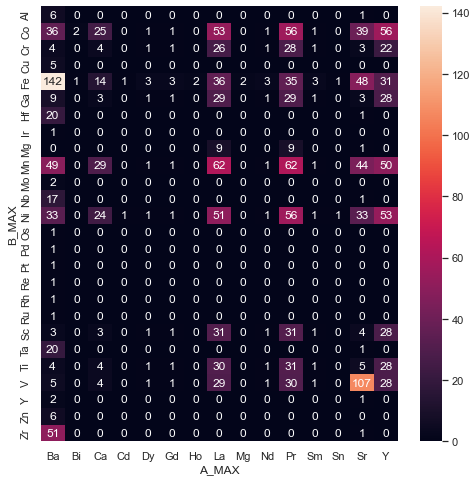

In [35]:
sns.heatmap(matrix_count, annot=True, fmt="d")

### Energy above hull ($E_{hull}$)

The histogram below shows the distribution of $E_{hull}$ for all perovskites in the dataset, among which 514 are stable and 1412 are unstable.

In [36]:
hist = px.histogram(df, x="ENERGY_ABOVE_HULL")
hist.update_layout(title_text=f"Histogram of E_hull")
hist.show()

In [37]:
df_ = df.copy()

df_["IS_UNSTABLE"] = df_["ENERGY_ABOVE_HULL"]>36
e_above_hull = df_.groupby(df_["IS_UNSTABLE"])["COMPOSITION"].count().rename("COUNT")
pie = px.pie(values=e_above_hull, names=["Stable", "Unstable"], title="Thermodynamic stability of perovskite oxides")
pie.show()

### Goldschmidt tolerance factor ($t$) and stability

After the determination of crystal structure based on Goldschmidt factor, the ratio of stable and unstable crystals per structure is plotted in the bar graph below. Interestingly, crystals that are predicted to be orthorhombic/rhombohedral are most likely to be stable, while hexagonal/tetragonal crystals are least likely. Cubic crystals are somewhere in between these two when it was discussed earlier that cubic crystals, in theory, are the most thermodynamically stable lattice structure for perovskites. 

The high stable rate for orthorhombic/rhombohedral crystals can be attributed to the fact that they are underrepresented in the dataset.

In [38]:
df_["STRUCTURE"] = pd.cut(x=df_["GOLDSCHMIDT_COMP_AVGD"],
                          bins=[0.71, 0.9, 1, 10],
                          labels=["Orthorhombic/rhombohedral", "Cubic", "Hexagonal/tetragonal"])

In [39]:
grouped_structures = df_.groupby("STRUCTURE")["IS_UNSTABLE"].value_counts(normalize=True).mul(100).rename('PERCENT').reset_index()

fig = px.bar(grouped_structures,
             x="STRUCTURE",
             y="PERCENT",
             color="IS_UNSTABLE")

fig.update_layout(title_text="Thermodynamic stability wrt structure based on t")

fig.show()

In [40]:
df_["STRUCTURE"].value_counts()

Cubic                        950
Hexagonal/tetragonal         669
Orthorhombic/rhombohedral    307
Name: STRUCTURE, dtype: int64

The plot below shows the average $E_{hull}$ with respect to $t$, superimposed on the histogram of $t$. As can be seen, $t$ of the perovskites have a relatively normal distribution. Interestingly, the average $E_{hull}$ steadily increases with $t$. This is consistent with earlier discussion stating that $t$ > 1.0 causes thermodynamic instability.

In [41]:
histogram_w_avg(50, "GOLDSCHMIDT_COMP_AVGD", "ENERGY_ABOVE_HULL")

### Octahedral factor ($\mu$) and stability

The stability based on octahedral factor was determined for each perovskite crystal. As can be seen below, crystals predicted to be stable based on their octahedral factor are more likely to be unstable. This is perhaps due to the assumption of mono-ionic crystals. 

In [42]:
df_["OCTAHEDRAL_UNSTABLE"] = df_["OCTAHEDRAL_COMP_AVGD"] < 0.41

In [43]:
grouped_structures = df_.groupby("OCTAHEDRAL_UNSTABLE")["IS_UNSTABLE"].value_counts(normalize=True).mul(100).rename('PERCENT').reset_index()

fig = px.bar(grouped_structures,
             x="OCTAHEDRAL_UNSTABLE",
             y="PERCENT",
             color="IS_UNSTABLE")

fig.update_layout(title_text="Thermodynamic stability wrt structure octahedral factor")

fig.show()

The plot below shows the average $E_{hull}$ with respect to $\mu$, superimposed on the histogram of $\mu$. As can be seen, $\mu$ of the perovskites has a left skew. Interestingly, the average $E_{hull}$ stays steady with $\mu$.

In [44]:
histogram_w_avg(15, "OCTAHEDRAL_COMP_AVGD", "ENERGY_ABOVE_HULL")

### Atomic weight of A cation with stability

Zhang et al. has shown that the stability of perovskites increase gradually as A becomes heavier i.e. $E_{hull}$ decreases with atomic weight of A [3]. Below we show a gradual decrease in average $E_{hull}$ as atomic weight of A increases. 

In [45]:
histogram_w_avg(15, "A_MAX_AT_WT", "ENERGY_ABOVE_HULL")

### Atomic packing factor and Sun factor and stability

The atomic packing factor ($\eta$) of a crystal quantifies the density of ions within the unit cell of a crystal. It can be calculated using the following formula:
$$\eta=\frac{\frac{M_A}{\rho_A} + \frac{M_B}{\rho_B} + 3\cdot\frac{M_X}{\rho_X}}{a^3}$$
where $M$ is for the molar mass of the ion, $\rho$ is the density of the ion, and $a$ is the lattice parameter of the unit cell which is equal to the bond length between B and O. 

As can be seen below, average $E_{hull}$ steadily increases with respect to APF.

In [46]:
df["APF"] = (np.divide(df["A_MAX_AT_WT"], 
                      df["A_MAX_DENSITY"], 
                      out=np.zeros_like(df["A_MAX_DENSITY"]), 
                      where = df["A_MAX_DENSITY"]!=0) +
            np.divide(df["B_MAX_AT_WT"], 
                      df["B_MAX_DENSITY"], 
                      out=np.zeros_like(df["B_MAX_DENSITY"]),
                      where = df["B_MAX_DENSITY"]!=0) + (3*22.4))/(df["B_O"])**3

df_["APF"] = df["APF"]

In [47]:
histogram_w_avg(20, "APF", "ENERGY_ABOVE_HULL")

The Sun factor (SF) is a quantity introduced in the 2017 paper of Sun et al [4]. It can be derived from the APF, $t$, and $\mu$ as shown below:

$$SF=(\mu+t)^\eta$$

Sun et al. has shown that $E_{hull}$ varies inversely with SF which is also shown on the below plot. One can see below that $E_{hull}$ increases with SF.

In [48]:
df["SUN_FACTOR"] = (df["GOLDSCHMIDT_COMP_AVGD"] + df["OCTAHEDRAL_COMP_AVGD"])**df["APF"]
df_["SUN_FACTOR"] = df["SUN_FACTOR"] 

In [49]:
histogram_w_avg(20, "SUN_FACTOR", "ENERGY_ABOVE_HULL")

In [50]:
df.to_csv("/Users/ian/Documents/GCash/Cadetship/stint2/eda/perovskite-ml/calc.csv")

## Machine learning modeling

For the modeling part of this project, the dataset will be limited to crystals with $E_{hull} < 400$ meV/atom to better fit the region of interest, which is for stable and nearly stable compounds. 

In [51]:
df = df[df["ENERGY_ABOVE_HULL"]<400]

In [52]:
df = df.replace(np.nan, 0)

In [53]:
string_columns_non_y = [i for i in df.columns if df[i].dtypes != "object" and i not in ["ENERGY_ABOVE_HULL", "FORMATION_ENERGY", "EnergyAboveHull", "Formation_energy"]]

In [54]:
X = df[string_columns_non_y]
y = df["ENERGY_ABOVE_HULL"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42)

In [55]:
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)

In [56]:
lr_i = LinearRegression()
svr_i = SVR()
rf_i = RandomForestRegressor()
mlp_i = MLPRegressor()
xgb_i = XGBRegressor()

estimator_list = [lr_i, svr_i, rf_i, mlp_i, xgb_i]
estimator_names = ["Linear regression",
                   "SVM",
                   "Random forest regressor",
                   "Multi-layer perceptron",
                   "XGBoost"]

In [57]:
def model_selection(estimator, name):
    
    if name == "XGBoost": 
        input = X_train
    else:
        input = X_train_
        
    scores = cross_validate(estimator,
                            input,
                            y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
    print("")
    print(f"{name} Mean Scores")
    print(f"RMSE: {(-scores['test_score'].mean())**(1/2.0)}")
    print("")
    
    return (-scores['test_score'].mean())**(1/2.0)

In [58]:
model_scores = []

for i in range(len(estimator_list)):
    model_scores.append(model_selection(estimator_list[i], estimator_names[i]))


Linear regression Mean Scores
RMSE: 128433586978695.66


SVM Mean Scores
RMSE: 81.1075629243277


Random forest regressor Mean Scores
RMSE: 44.05873452985197


Multi-layer perceptron Mean Scores
RMSE: 52.16194065769257


XGBoost Mean Scores
RMSE: 44.01093331955984



In [59]:
xgb_i.fit(X_train, y_train)
f_i = xgb_i.feature_importances_

In [60]:
df_fi = pd.DataFrame(list(zip(X.columns, f_i)), columns=["FEATURE", "IMPORTANCE"])
df_fi = df_fi.sort_values("IMPORTANCE", ascending=False)
df_fi

,FEATURE,IMPORTANCE
126,B_MAX_AT_RAD,0.410524
870,AB_AVG_CTE,0.075651
174,B_MAX_ND_VALENCE,0.061857
108,B_MAX_BCC_ENERGY,0.050108
902,RATIO_ATOM_RAD,0.030229
...,...,...
505,ALL_MAX_B_PERIOD,0.000000
506,ALL_MIN_A_PERIOD,0.000000
507,ALL_MIN_B_PERIOD,0.000000
508,RANGE_A_PERIOD,0.000000


### Hyperparameter tuning

In [61]:
class MostImportFeaturesOnly(BaseEstimator, TransformerMixin):
    def __init__(self, f, n=None):
        self.n = n
        self.f = f
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        top = list((self.f).sort_values("IMPORTANCE").tail(self.n).index)
        return X.iloc[:, top]

In [63]:
# # Doing gridsearch that searches through all possible number of features
# # on top of other XGBoost hyperparameter takes too much time

# # Determining optimum number of features first, then 
# # optimizing XGBoost hyperparameters

# pipeline_best_num_features = Pipeline(
#     [
#         ("most_imp", MostImportFeaturesOnly(f=df_fi)),
#         ("xgbr", XGBRegressor())
#     ]
# )
# params_bnf = {'most_imp__n': np.arange(0,X_train.shape[1],5)}

# gs_bnf = GridSearchCV(estimator=pipeline_best_num_features,
#                       param_grid=params_bnf,
#                       scoring='neg_mean_squared_error',
#                       verbose=1)

# gs_bnf.fit(X_train, y_train)

# print("XGBoost Regression Report")
# print("Best number of feature:", gs_bnf.best_params_)
# print("Lowest RMSE: ", (-gs_bnf.best_score_)**(1/2.0))

Fitting 5 folds for each of 185 candidates, totalling 925 fits
XGBoost Regression Report
Best number of feature: {'most_imp__n': 105}
Lowest RMSE:  38.58726423174326


In [64]:
# gs_bnf_filename = "gs_bnf.pkl"
# joblib.dump(gs_bnf, gs_bnf_filename)

gs_bnf = joblib.load("gs_bnf.pkl")

In [93]:
bnf = gs_bnf.best_params_['most_imp__n']
best_rmse = (-gs_bnf.best_score_)**(1/2.0)

In [120]:
num_feature = np.arange(0,X_train.shape[1],5)
mean_rmse = ((-gs_bnf.cv_results_["mean_test_score"])**(1.0/2))

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=num_feature,
               y=mean_rmse,
               line_shape="spline")
)

fig.update_layout(
        title_text="RMSE vs. number of features"
)

# Set x-axis title
fig.update_xaxes(title_text="Number of features")

# Set y-axes titles
fig.update_yaxes(title_text="RMSE")

annotation = {
    'x': bnf,
    'y': best_rmse,
    'ax': 30,
    'ay': 40,
    'text': f'Lowest RMSE - ±{round(best_rmse,2)} at {bnf} features',  # text
    'showarrow': True,  # would you want to see arrow
    'arrowhead': 3,  # which type for arrowhead
    'font': {'size': 15, 'color': 'black'},  # font style
}
fig.add_annotation(annotation)
fig.show()

In [96]:
# pipeline = Pipeline(
#     [
#         ("most_imp", MostImportFeaturesOnly(f=df_fi)),
#         ("xgbr", XGBRegressor())
#     ]
# )

# params = { 
#             'most_imp__n': np.arange(95,115,5),
#             'xgbr__max_depth': [3,6,10],
#             'xgbr__learning_rate': [0.01, 0.05, 0.1],
#             'xgbr__n_estimators': [100, 500, 1000],
#             'xgbr__colsample_bytree': [0.3, 0.7]
#         }

# gs = GridSearchCV(estimator=pipeline,
#                   param_grid=params,
#                   scoring='neg_mean_squared_error',
#                   verbose=1)

# gs.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(estimator=Pipeline(steps=[('most_imp',
                                        MostImportFeaturesOnly(f=              FEATURE  IMPORTANCE
126      B_MAX_AT_RAD    0.410524
870        AB_AVG_CTE    0.075651
174  B_MAX_ND_VALENCE    0.061857
108  B_MAX_BCC_ENERGY    0.050108
902    RATIO_ATOM_RAD    0.030229
..                ...         ...
505  ALL_MAX_B_PERIOD    0.000000
506  ALL_MIN_A_PERIOD    0.000000
507  ALL_MIN_B_PERIOD    0.000000
508    RANGE_A_PERIOD    0.000000
525   RANGE_B_VALENCE    0....
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None, ...))]),
             param_grid={'most_imp__n': array([ 95, 100, 105, 110]),
                         'xgbr__colsample_bytree': [0.3, 0.7],
                         'xgbr__learning_rate': [0.01, 0.05, 0.1],
                         'xgbr__max_depth': [3, 6, 10],
                         'xgbr__n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=1)

In [98]:
# gs_filename = "gs.pkl"
# joblib.dump(gs, gs_filename)

gs = joblib.load("gs.pkl")

print("Best parameters:", gs.best_params_)
print("Lowest RMSE: ", (-gs.best_score_)**(1/2.0))

Best parameters: {'most_imp__n': 105, 'xgbr__colsample_bytree': 0.3, 'xgbr__learning_rate': 0.05, 'xgbr__max_depth': 6, 'xgbr__n_estimators': 1000}
Lowest RMSE:  37.62030166663581


In [99]:
xgb_fin = gs.best_estimator_
y_pred = xgb_fin.predict(X_test)
rmse_fin = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE of XGBRegressor on X_test: {rmse_fin}")

RMSE of XGBRegressor on X_test: 38.44647626967033


In [110]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=y_test,
        y=y_pred,
        mode="markers",
        name="Predictions",
        showlegend=False
    ),
    
)

fig.add_trace(
    go.Scatter(
        x=np.linspace(0, 400, num=1000),
        y=np.linspace(0, 400, num=1000),
        line_shape="spline",
        name="Perfect model",
        showlegend=False
    ), 
)

# Add figure title
fig.update_layout(
        title_text="Predicted E_hull vs. actual E_hull",
        width=750,
        height=750
    )

# Set x-axis title
fig.update_xaxes(title_text="Actual E_hull")

# Set y-axes titles
fig.update_yaxes(title_text="Predicted E_hull", secondary_y=True)
fig.update_yaxes(title_text="Predicted E_hull", secondary_y=False)
        
fig.show()


---

#### References

[1] Jacobs, Ryan, et al. "Material discovery and design principles for stable, high activity perovskite cathodes for solid oxide fuel cells." Advanced Energy Materials 8.11 (2018): 1702708.

[2] Ward, Logan, et al. "A general-purpose machine learning framework for predicting properties of inorganic materials." npj Computational Materials 2.1 (2016): 1-7.

[3] Zhang, Tao, Zenghua Cai, and Shiyou Chen. "Chemical trends in the thermodynamic stability and band gaps of 980 halide double perovskites: A high-throughput first-principles study." ACS Applied Materials & Interfaces 12.18 (2020): 20680-20690.

[4] Sun, Qingde, and Wan-Jian Yin. "Thermodynamic stability trend of cubic perovskites." Journal of the American Chemical Society 139.42 (2017): 14905-14908.

